In [1]:
import re
import numpy as np
import torch
import torch.autograd as ag
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import random

# Deep Learning for NLP - lab exercise 1

In this first lab exercise we will implement a simple bag-of-word classifier, i.e. a classifier that ignores the sequential structure of the sentence. The goal is to predict if a sentence is a positive or negative review of a movie. We will use a dataset constructed from IMDB.

1. Load and clean the data
2. Preprocess the data for the NN
3. Module definition
4. Train the network!

We will implement this model with Pytorch, the most popular deep learning framework for Natural Language Processing. You can use the following links for help:
* turorials: http://pytorch.org/tutorials/
* documentation: http://pytorch.org/docs/master/ 

**Hard deadline**: December 3, 2019


## Report

On top of this notebook, you must submit a report explaining your neural network, it's training method and report+analyse results, for example with different hyper-parameters (number of hidden layers, different embedding size, different hidden representation size, w or w/o dropout...you choose what you want to explore!).
You can also report results with different training dataset sizes (how does the number of training instances impact dev/test results? => *WARNING* obviously, here you change the training set size but you freeze the dev/test sets).

Training with the full dataset may be slow depending on your computer.

## Data

The data can be download here: http://teaching.caio-corro.fr/2019-2020/OPT7/imdb.zip

There are two files: one with positive reviews (imdb.pos) and one with negative reviews (imdb.neg). Each file contains 300000 reviews, one per line.


The following functions can be used to load and clean the data.

In [2]:
# Tokenize a sentence
def clean_str(string, tolower=True):
    """
    Tokenization/string cleaning.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    if tolower:
        string = string.lower()
    return string.strip()


# reads the content of the file passed as an argument.
# if limit > 0, this function will return only the first "limit" sentences in the file.
def loadTexts(filename, limit=-1):
    f = open(filename)
    dataset=[]
    line =  f.readline()
    cpt=1
    skip=0
    while line :
        cleanline = clean_str(f.readline()).split()
        if cleanline: 
            dataset.append(cleanline)
        else: 
            line = f.readline()
            skip+=1
            continue
        if limit > 0 and cpt >= limit: 
            break
        line = f.readline()
        cpt+=1        
        
    f.close()
    print("Load ", cpt, " lines from ", filename , " / ", skip ," lines discarded")
    return dataset


The following cell load the first 5000 sentences in each review set.

In [3]:
LIM=5000
txtfile = 'imdb.pos'  # path of the file containing positive reviews
postxt = loadTexts(txtfile,limit=LIM)

txtfile = 'imdb.neg' # path of the file containing negative reviews
negtxt = loadTexts(txtfile,limit=LIM)

Load  5000  lines from  imdb.pos  /  1  lines discarded
Load  5000  lines from  imdb.neg  /  1  lines discarded


Split the data between train / dev / test, for example by creating lists txt_train, label_train, txt_dev, ... You should take care to keep a 50/50 ratio between positive and negative instances in each set.

In [4]:
data = postxt + negtxt
label = np.concatenate((np.ones(len(postxt)),np.zeros(len(negtxt))),axis=0)

In [5]:
print(data[10])
print(label[10])

['get', 'in', 'the', 'back', 'of', 'the', 'van', '!']
1.0


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.1, random_state=1 ,stratify=label)
X_train,X_dev,y_train,y_dev = train_test_split(X_train , y_train , test_size=0.1, random_state = 1 , stratify=y_train)

In [7]:
print(X_train[10])
print(y_train[10])

['laughton', 'enjoyable', 'in', 'this', 'low', 'budget', 'pirate', 'saga']
0.0


# Converting data to Pytorch tensors

We will first convert data to Pytorch tensors so they can be used in a neural network.
To do that, you must first create a dictionnary that will map words to integers.
Add to the dictionnary only words that are in the training set (be sure to understand why we do that!).

Then, you can convert the data to tensors:
- use tensors of longs: both the sentence and the label will be represented as integers, not floats!
- these tensors do not require a gradient

A tensor representing a sentence is composed of the integer representation of each word, e.g. [10, 256, 3, 4].
Note that some words in the dev and test sets may not be in the dictionnary! (i.e. unknown words)
You can just skip them.

In [8]:
class Dict:
    def __init__(self, words, unk=None):
        self._unk = unk
        self._word_to_id = dict()
        self._id_to_word = list()

        if unk in words:
            raise RuntimeError("UNK word exists in vocabulary")

        if unk is not None:
            self.unk_index = self._add_word(unk)

        for word in words:
            self._add_word(word)

    # for internal use only!
    def _add_word(self, word):
        if word not in self._word_to_id:
            id = len(self._id_to_word)
            self._word_to_id[word] = id
            self._id_to_word.append(word)
            return id
        else:
            return self._word_to_id[word]

    def str_to_id(self, word):
        if self._unk is not None:
            return self._word_to_id.get(word, self.unk_index)
        else:
            return self._word_to_id[word]

    def id_to_str(self, id):
        return self._id_to_word[id]

    def __len__(self):
        return len(self._word_to_id)

    def has_unk(self):
        return self._unk is not None
    
    def unk(self):
        return self.unk_index

In [9]:
#Creating a dict where each word is associated to a number
token_index = {}
for sent in X_train:
    for word in sent:
        if word not in token_index:
            token_index[word] = len(token_index) + 1
            
#Don't forget to add the unk = True because some words maybe in the dev or test but not in the train
token_index = Dict(token_index, unk=True)


# Neural network definition

The neural network should be defined as follows:
- it takes as input a tensor that is a sequence of integers indexing word embeddings
- it retrieves the word embeddings from an embedding table
- it constructs the "input" of the MLP by summing over all embeddingsÂ (i.e. bag-of-word model)
- it build a hidden represention using a MLP (1 layer? 2 layers? experiment! but maybe first try wihout any hidden layer...)
- it project the hidden representation to the output space: it is a binary classification task, so the output space is a scalar where a negative (resp. positive) value means the review is negative (resp. positive).

In [10]:
class CBOW_classifier(nn.Module):
    def __init__(self, vocab_size , embedding_dim=100):
        super(CBOW_classifier, self).__init__()
        # To create an embedding table: https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding
        self.emb_db = torch.nn.Embedding(num_embeddings = vocab_size ,embedding_dim=embedding_dim)
        
        #1st hidden layer
       # self.hidden1 = torch.nn.Linear(embedding_dim , 50)
        #ouput layer
        self.output = torch.nn.Linear(embedding_dim,1)
        
        
        #initialisation
#         torch.nn.init.xavier_uniform_(self.hidden1.weight.data)
#         torch.nn.init.zeros_(self.hidden1.bias.data)
        
        torch.nn.init.xavier_uniform_(self.output.weight.data)
        torch.nn.init.zeros_(self.output.bias.data)
        
        
    def forward(self, inputs):
        
        x = self.emb_db(inputs)
        x = torch.sum(x ,dim=0)
      #  x = F.tanh(self.hidden1(x))
        
        output = F.sigmoid(self.output(x))
        
        return(output)

## Loss function

Create a loss function builder.

- Pytorch loss functions are documented here: https://pytorch.org/docs/stable/nn.html#loss-functions
- In our case, we are interested in *BCELoss* and *BCEWithLogitsLoss*. Read their documentation and choose the one that fits with your network output

In [11]:
loss = torch.nn.BCELoss()

## Training loop

Write your training loop!

- parameterizable number of epochs
- at each epoch, print the mean loss and the dev accuracy

In [12]:
model1 = CBOW_classifier(vocab_size=len(token_index)+1)

In [15]:
def train(model , epochs, lr ,X_train ,y_train , X_dev , y_dev , optimizer ="SGD"):
    
    #defining various types of optimizer
    if (optimizer=="SGD"):
        optimizer = torch.optim.SGD(params=model.parameters(), lr =lr, weight_decay=1e-4)   
    if (optimizer== "AdaDelta"):
        optimizer = torch.optim.Adadelta(params=model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)
        
        
    #variables to see the progression
    mean_loss_train = []
    mean_loss_dev = []
    acc_train = []
    acc_dev = []
    
    
    #passe le modele en mode training
    model.train()
    
    for i in range(epochs):
        #defining parameters to print the evolution of the NN
        accuracy = 0
        mean_loss = 0
        
        #shuffle to reduce overfitting
        c = list(zip(X_train, y_train))
        random.shuffle(c)
        X_train, y_train = zip(*c)
        
        for sent,label in zip(X_train , y_train):
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            #creating the tensors for inputs
            data = torch.LongTensor([token_index.str_to_id(word) for word in sent])
            label = torch.Tensor([label])
            
            #prediction and loss
            pred = model(data)
            output = loss(pred , label)
            mean_loss+=output.item()
            
            #backward and updates
            output.backward()
            optimizer.step()

            #computing accuracy
            if (pred >= 0.5 and label==1):
                accuracy += 1
            if(pred<0.5 and label==0):
                accuracy += 1
            
        mean_loss_train.append(mean_loss/len(X_train))
        acc_train.append(accuracy/len(X_train))
        
        print("EPOCH" , str(i+1) ,"On training : Mean Loss :" , mean_loss/len(X_train) , "Accuracy :" ,accuracy/len(X_train))


        mean_loss = 0
        accuracy = 0
        
        ###testing on dev data#########
        for sent,label in zip(X_dev,y_dev):
            data = torch.LongTensor([token_index.str_to_id(word) for word in sent])
            label = torch.Tensor([label])
            
            #prediction and loss
            pred = model(data)
            output = loss(pred , label)
            
            mean_loss+=output.item()
            
            
            #computing accuracy
            if (pred >= 0.5 and label==1):
                accuracy += 1
            if(pred<0.5 and label==0):
                accuracy += 1
            
        print("EPOCH" , str(i+1) ,"On Dev  :Mean Loss :" , mean_loss/len(X_dev) , "Accuracy :" ,accuracy/len(X_dev))
        print()

        mean_loss_dev.append(mean_loss/len(X_dev))
        acc_dev.append(accuracy/len(X_dev))
          
            
            
    #Plotting loss accuracy for  test and train
    plt.plot(acc_train , label='Train')
    plt.plot(acc_dev, label="Dev")
    plt.title("Accuracy")
    plt.legend()
    plt.figure()
    
    plt.plot(mean_loss_train , label='Train')
    plt.plot(mean_loss_dev, label="Dev")
    plt.title("Loss")
    plt.legend()
    plt.figure()


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


EPOCH 1 On training : Mean Loss : 11.291745535316766 Accuracy : 0.5867901234567902
EPOCH 1 On Dev  :Mean Loss : 10.870398487242136 Accuracy : 0.6088888888888889

EPOCH 2 On training : Mean Loss : 10.086392111378057 Accuracy : 0.6398765432098765
EPOCH 2 On Dev  :Mean Loss : 9.606578585294027 Accuracy : 0.6422222222222222

EPOCH 3 On training : Mean Loss : 9.001342265065556 Accuracy : 0.677037037037037
EPOCH 3 On Dev  :Mean Loss : 9.633064150677049 Accuracy : 0.6477777777777778

EPOCH 4 On training : Mean Loss : 8.887184237022584 Accuracy : 0.681358024691358
EPOCH 4 On Dev  :Mean Loss : 10.13446922901932 Accuracy : 0.65

EPOCH 5 On training : Mean Loss : 8.899059735638142 Accuracy : 0.6824691358024692
EPOCH 5 On Dev  :Mean Loss : 9.42115355458442 Accuracy : 0.6655555555555556

EPOCH 6 On training : Mean Loss : 8.460575080621174 Accuracy : 0.7
EPOCH 6 On Dev  :Mean Loss : 8.91239925754685 Accuracy : 0.6888888888888889

EPOCH 7 On training : Mean Loss : 8.035290273050187 Accuracy : 0.71469

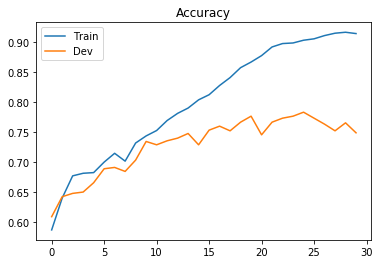

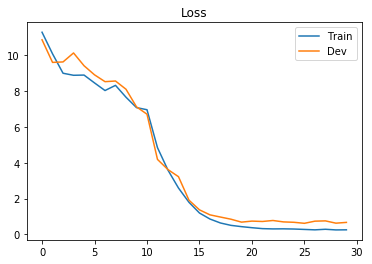

<Figure size 432x288 with 0 Axes>

In [34]:
train(model1 , 30 , lr=0.1 , X_train =X_train ,y_train = y_train , X_dev = X_dev , y_dev = y_dev)

In [16]:
model2 = CBOW_classifier(vocab_size=len(token_index)+1)

In [17]:
train(model2 , 20 , lr=0.1 , X_train =X_train ,y_train = y_train , X_dev = X_dev , y_dev = y_dev ,optimizer="AdaDelta")

C:\Users\berte\Anaconda3\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


KeyboardInterrupt: 

In [64]:
##test on test data with the two different models
mean_loss = 0
accuracy = 0
        
###testing on dev data#########
for sent,label in zip(X_test,y_test):
    data = torch.LongTensor([token_index.str_to_id(word) for word in sent])
    label = torch.Tensor([label])
            
    #prediction and loss
    pred = model1(data)
    output = loss(pred , label)
    mean_loss+=output.item()
                        
            
    #computing accuracy
    if (pred >= 0.5 and label==1):
        accuracy += 1
    if(pred<0.5 and label==0):
        accuracy += 1
            
print("Accuracy on test set for model 1 is" , accuracy/len(X_test))
            

Accuracy on test set for model 1 is 0.765


In [65]:
##test on test data with the two different models
mean_loss = 0
accuracy = 0
        
###testing on dev data#########
for sent,label in zip(X_test,y_test):
    data = torch.LongTensor([token_index.str_to_id(word) for word in sent])
    label = torch.Tensor([label])
            
    #prediction and loss
    pred = model2(data)
    output = loss(pred , label)
    mean_loss+=output.item()
                        
            
    #computing accuracy
    if (pred >= 0.5 and label==1):
        accuracy += 1
    if(pred<0.5 and label==0):
        accuracy += 1
            
print("Accuracy on test set for model 2 is" , accuracy/len(X_test))
            

Accuracy on test set for model 2 is 0.762


# ONE HIDDEN LAYER

In [21]:
class CBOW_classifier_1_hidden(nn.Module):
    def __init__(self, vocab_size , embedding_dim=100):
        super(CBOW_classifier_1_hidden, self).__init__()
        # To create an embedding table: https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding
        self.emb_db = torch.nn.Embedding(num_embeddings = vocab_size ,embedding_dim=embedding_dim)
        
        #1st hidden layer with 50 hidden unit
        self.hidden1 = torch.nn.Linear(embedding_dim , 50)
        #ouput layer
        self.output = torch.nn.Linear(50,1)
        
        
        #initialisation
        torch.nn.init.xavier_uniform_(self.hidden1.weight.data)
        torch.nn.init.zeros_(self.hidden1.bias.data)
        
        torch.nn.init.xavier_uniform_(self.output.weight.data)
        torch.nn.init.zeros_(self.output.bias.data)
        
        
    def forward(self, inputs):
        
        x = self.emb_db(inputs)
        x = torch.sum(x ,dim=0)
        x = F.tanh(self.hidden1(x))
        
        output = F.sigmoid(self.output(x))
        
        return(output)

In [22]:
loss = torch.nn.BCELoss()

In [23]:
model3 = CBOW_classifier_1_hidden(vocab_size=len(token_index)+1)

In [25]:
train(model3 , 30 , lr=0.01 , X_train =X_train ,y_train = y_train , X_dev = X_dev , y_dev = y_dev)

EPOCH 1 On training : Mean Loss : 0.357531932736245 Accuracy : 0.8533333333333334
EPOCH 1 On Dev  :Mean Loss : 0.6160470587802572 Accuracy : 0.7588888888888888

EPOCH 2 On training : Mean Loss : 0.3100253975346349 Accuracy : 0.8660493827160494
EPOCH 2 On Dev  :Mean Loss : 0.5956754077449214 Accuracy : 0.7744444444444445

EPOCH 3 On training : Mean Loss : 0.29275605974001395 Accuracy : 0.8769135802469136
EPOCH 3 On Dev  :Mean Loss : 0.5992114830723505 Accuracy : 0.7722222222222223

EPOCH 4 On training : Mean Loss : 0.28656022726130037 Accuracy : 0.8755555555555555
EPOCH 4 On Dev  :Mean Loss : 0.6176246209507614 Accuracy : 0.7755555555555556

EPOCH 5 On training : Mean Loss : 0.27232481047487433 Accuracy : 0.8891358024691358
EPOCH 5 On Dev  :Mean Loss : 0.6085981088182679 Accuracy : 0.7777777777777778

EPOCH 6 On training : Mean Loss : 0.2570951886244856 Accuracy : 0.8949382716049382
EPOCH 6 On Dev  :Mean Loss : 0.6510299438641192 Accuracy : 0.7788888888888889

EPOCH 7 On training : Mean

KeyboardInterrupt: 

In [71]:
##test on test data with the two different models
mean_loss = 0
accuracy = 0
        
###testing on dev data#########
for sent,label in zip(X_test,y_test):
    data = torch.LongTensor([token_index.str_to_id(word) for word in sent])
    label = torch.Tensor([label])
            
    #prediction and loss
    pred = model3(data)
    output = loss(pred , label)
    mean_loss+=output.item()
                        
            
    #computing accuracy
    if (pred >= 0.5 and label==1):
        accuracy += 1
    if(pred<0.5 and label==0):
        accuracy += 1
            
print("Accuracy on test set for model 3 is" , accuracy/len(X_test))
            

Accuracy on test set for model 3 is 0.738


# TWO HIDDEN LAYERS

In [76]:
class CBOW_classifier_2_hidden(nn.Module):
    def __init__(self, vocab_size , embedding_dim=100):
        super(CBOW_classifier_2_hidden, self).__init__()
        # To create an embedding table: https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding
        self.emb_db = torch.nn.Embedding(num_embeddings = vocab_size ,embedding_dim=embedding_dim)
        
        #1st hidden layer with 50 hidden units
        self.hidden1 = torch.nn.Linear(embedding_dim , 50)
        #2nd hidden layer with 25 hidden units
        self.hidden2 = torch.nn.Linear(50 , 25)
        #ouput layer
        self.output = torch.nn.Linear(25,1)
        
        
        #initialisation
        torch.nn.init.xavier_uniform_(self.hidden1.weight.data)
        torch.nn.init.zeros_(self.hidden1.bias.data)
        
        torch.nn.init.xavier_uniform_(self.hidden2.weight.data)
        torch.nn.init.zeros_(self.hidden2.bias.data)
        
        torch.nn.init.xavier_uniform_(self.output.weight.data)
        torch.nn.init.zeros_(self.output.bias.data)
        
        
    def forward(self, inputs):
        
        x = self.emb_db(inputs)
        x = torch.sum(x ,dim=0)
        x = F.tanh(self.hidden1(x))
        x = F.tanh(self.hidden2(x))
        output = F.sigmoid(self.output(x))
        
        return(output)

In [77]:
loss = torch.nn.BCELoss()

In [78]:
model4 = CBOW_classifier_2_hidden(vocab_size=len(token_index)+1)

EPOCH 1 On training : Mean Loss : 0.5747288546020889 Accuracy : 0.7469135802469136
EPOCH 1 On Dev  :Mean Loss : 0.7029975880470334 Accuracy : 0.7166666666666667

EPOCH 2 On training : Mean Loss : 0.5528122387815124 Accuracy : 0.7590123456790123
EPOCH 2 On Dev  :Mean Loss : 0.7134942867671553 Accuracy : 0.7144444444444444

EPOCH 3 On training : Mean Loss : 0.5329229201980972 Accuracy : 0.7703703703703704
EPOCH 3 On Dev  :Mean Loss : 0.6116946510448017 Accuracy : 0.7288888888888889

EPOCH 4 On training : Mean Loss : 0.5030224984961261 Accuracy : 0.7871604938271605
EPOCH 4 On Dev  :Mean Loss : 0.6909163912553857 Accuracy : 0.6877777777777778

EPOCH 5 On training : Mean Loss : 0.5005881005143287 Accuracy : 0.7879012345679013
EPOCH 5 On Dev  :Mean Loss : 0.6077402663541337 Accuracy : 0.7233333333333334

EPOCH 6 On training : Mean Loss : 0.5057087111739096 Accuracy : 0.7817283950617284
EPOCH 6 On Dev  :Mean Loss : 0.6545839924005689 Accuracy : 0.7166666666666667

EPOCH 7 On training : Mean L

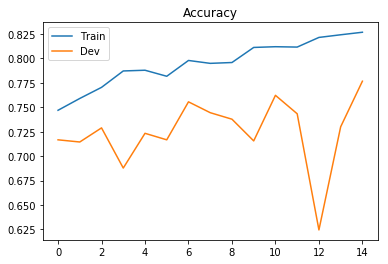

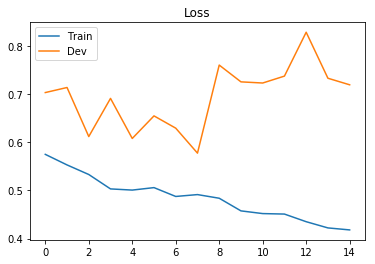

<Figure size 432x288 with 0 Axes>

In [80]:
train(model4 , 15 , lr=0.1 , X_train =X_train ,y_train = y_train , X_dev = X_dev , y_dev = y_dev)

In [82]:
##test on test data with the two different models
mean_loss = 0
accuracy = 0
        
###testing on dev data#########
for sent,label in zip(X_test,y_test):
    data = torch.LongTensor([token_index.str_to_id(word) for word in sent])
    label = torch.Tensor([label])
            
    #prediction and loss
    pred = model4(data)
    output = loss(pred , label)
    mean_loss+=output.item()
                        
            
    #computing accuracy
    if (pred >= 0.5 and label==1):
        accuracy += 1
    if(pred<0.5 and label==0):
        accuracy += 1
            
print("Accuracy on test set for model 4 is" , accuracy/len(X_test))
            

Accuracy on test set for model 4 is 0.747
